In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import dataiku
from dataiku import pandasutils as pdu
import pandas as pd
from os import listdir
from os.path import isfile, join
import random 
from tqdm import tqdm
import cv2
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import keras as k

Using TensorFlow backend.


In [3]:
# Example: load a DSS dataset as a Pandas dataframe
mydataset = dataiku.Dataset("train_labels")
labels = mydataset.get_dataframe()
labels.head(5)

,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


## Using Transfer Learning

usefull ref: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

### Loading Resnet pretrained model

In [4]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

In [ ]:
model = ResNet50(weights='imagenet')

### Loading the data

In [9]:
# size of image
smallimg_size = 224

In [10]:
# get images list
mypath = "/data/pgutierrez/invasive/train"
images = [f for f in listdir(mypath) if isfile(join(mypath, f))]
random.shuffle(images)
print len(images)

2295


In [11]:
x_train = []
y_train = []

for f in tqdm(images, miniters=100):
    im_number = int(f.split('.')[0])
    y_train.append(int(labels[labels['name']==im_number]['invasive']))   
    img = image.load_img(mypath+'/'+f, target_size=(smallimg_size, smallimg_size))
    x_train.append(image.img_to_array(img))


y_train = np.array(y_train)
x_train = preprocess_input(np.array(x_train))

print(x_train.shape)
print(y_train.shape)

split = 1836
x_train, x_valid, y_train, y_valid = x_train[:split], x_train[split:], y_train[:split], y_train[split:]

print(x_valid.shape)
print(y_valid.shape)

100%|██████████| 2295/2295 [00:54<00:00, 42.34it/s]


(2295, 224, 224, 3)
(2295,)
(459, 224, 224, 3)
(459,)


can we use the pretrained network directly ?

In [8]:
preds = model.predict(x_train)

('Predicted:', [(u'n02727426', u'apiary', 0.058525357), (u'n02504458', u'African_elephant', 0.036575068), (u'n01871265', u'tusker', 0.035070252)])


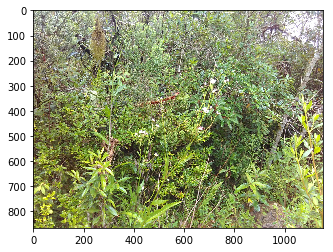

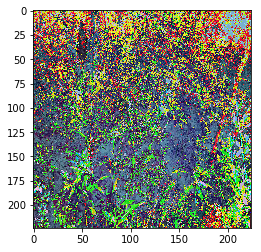

In [9]:
imagenum = 1
plt.figure()
imshow(image.load_img(mypath+'/'+images[imagenum]))
plt.figure()
imshow(x_train[imagenum])
print('Predicted:', decode_predictions(preds, top=3)[imagenum])

('Predicted:', [(u'n12768682', u'buckeye', 0.128217), (u'n04465501', u'tractor', 0.05178437), (u'n04326547', u'stone_wall', 0.051156271)])


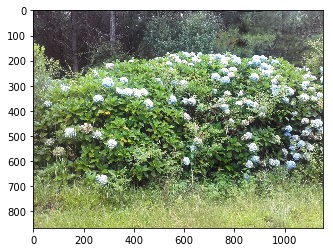

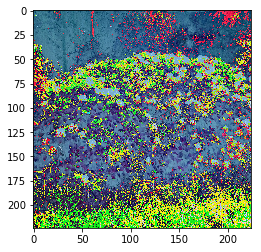

In [10]:
imagenum = 0
plt.figure()
imshow(image.load_img(mypath+'/'+images[imagenum]))
plt.figure()
imshow(x_train[imagenum])
print('Predicted:', decode_predictions(preds, top=3)[imagenum])

More details on archi of Resnet:  
https://github.com/fchollet/keras/blob/master/keras/applications/resnet50.py

More details on preprocesing used here:   
https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py

Though not that bad, this does not help us much. We now need to use transfer learning ! 

### Transfer Learning: last layer

In [11]:
features_train = model.predict(x_train)
features_valid = model.predict(x_valid)

In [12]:
print features_train.shape
print features_valid.shape

(1836, 1000)
(459, 1000)


Now we don't really need to work with Keras anymore. Logistic regression or svm from scikit learn might work just as well !

In [13]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(features_train,y_train)
yprobas = clf.predict_proba(features_valid)[:,1]
ypred = [0 if x <0.5 else 1 for x in yprobas]
print "AUC: ", roc_auc_score(y_valid, yprobas, average='macro', sample_weight=None)
print classification_report(y_valid,ypred)

AUC:  0.903562707134
             precision    recall  f1-score   support

          0       0.66      0.81      0.73       147
          1       0.90      0.80      0.85       312

avg / total       0.82      0.81      0.81       459



In [14]:
from sklearn.svm import SVC
clf = SVC(C=1.0, kernel='rbf',probability=True)
clf.fit(features_train,y_train)
yprobas = clf.predict_proba(features_valid)[:,1]
ypred = [0 if x <0.5 else 1 for x in yprobas]
print "AUC: ", roc_auc_score(y_valid, yprobas, average='macro', sample_weight=None)
print classification_report(y_valid,ypred)

AUC:  0.891003837432
             precision    recall  f1-score   support

          0       0.64      0.93      0.76       147
          1       0.96      0.76      0.84       312

avg / total       0.85      0.81      0.82       459



Not bad... but we are using predictions which may not be the most informative layer.  

### Transfer learning: arbitrary layer

In [15]:
base_model = ResNet50(weights='imagenet')

In [16]:
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D) (None, 230, 230, 3)   0           input_2[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_2[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [17]:

model = Model(inputs=base_model.input, outputs=base_model.get_layer('flatten_2').output)

In [18]:
features_train = model.predict(x_train)
features_valid = model.predict(x_valid)

In [19]:
print features_train.shape
print features_valid.shape

(1836, 2048)
(459, 2048)


In [20]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(features_train,y_train)
yprobas = clf.predict_proba(features_valid)[:,1]
ypred = [0 if x <0.5 else 1 for x in yprobas]
print "AUC: ", roc_auc_score(y_valid, yprobas, average='macro', sample_weight=None)
print classification_report(y_valid,ypred)

AUC:  0.986416361416
             precision    recall  f1-score   support

          0       0.89      0.97      0.93       147
          1       0.98      0.95      0.96       312

avg / total       0.95      0.95      0.95       459



(mikedrop)

### Submit! 

In [21]:
smallimg_size = 224 
# get images list
mypath = "/data/pgutierrez/invasive/test"
images = [f for f in listdir(mypath) if isfile(join(mypath, f))]
random.shuffle(images)
print len(images)

x_test = []
names=[]
for f in tqdm(images, miniters=100):
    im_number = int(f.split('.')[0])
    names.append(im_number)
    img = image.load_img(mypath+'/'+f, target_size=(smallimg_size, smallimg_size))
    x_test.append(image.img_to_array(img))

x_test = preprocess_input(np.array(x_test))

features_test = model.predict(x_test)
yprobas = clf.predict_proba(features_test)[:,1]
sub = pd.DataFrame(np.stack([names,yprobas.reshape(1531,)],axis=1),columns = ["name","invasive"])
sub["name"]=sub["name"].astype(int)
sub 

  0%|          | 0/1531 [00:00<?, ?it/s]

1531


100%|██████████| 1531/1531 [00:32<00:00, 46.87it/s]


,name,invasive
0,40,4.906099e-05
1,870,8.038289e-03
2,666,4.815126e-02
3,222,9.999798e-01
4,1184,3.377230e-02
5,551,2.843322e-05
6,909,1.000000e+00
7,38,1.073808e-07
8,687,1.268505e-04
9,1209,5.069434e-03


0.96... do I have problem with my eval ? 

#### Submit with reg log learned on all data.

In [22]:
x = np.vstack([features_train,features_valid]) 
y = np.concatenate([y_train,y_valid]) 
x.shape, y.shape

((2295, 2048), (2295,))

In [23]:
clf = LogisticRegression()
clf.fit(x,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
yprobas = clf.predict_proba(features_test)[:,1]
sub = pd.DataFrame(np.stack([names,yprobas.reshape(1531,)],axis=1),columns = ["name","invasive"])
sub["name"]=sub["name"].astype(int)
sub 

,name,invasive
0,40,2.495960e-05
1,870,5.113139e-03
2,666,1.519761e-01
3,222,9.999292e-01
4,1184,1.229950e-02
5,551,5.588495e-05
6,909,1.000000e+00
7,38,9.776547e-09
8,687,2.180514e-04
9,1209,4.171846e-05


-> 0.97267 on leaderboard. Huge improovement

### Transfer Learning: Fine tuning

Limit of the previous approach:   
- no data augmentation
- can we fine tune our resnet model ? 

In [5]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

img_rows, img_cols, img_channel = 224, 224, 3

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

In [6]:
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 20

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(x_train)


history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_valid, y_valid),
    callbacks=[ModelCheckpoint('/data/pgutierrez/invasive/models/VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)]
)

Epoch 1/20
57/57 [==============================] - 111s - loss: 0.5964 - acc: 0.8306 - val_loss: 0.2271 - val_acc: 0.9216
Epoch 2/20
57/57 [==============================] - 115s - loss: 0.2145 - acc: 0.9207 - val_loss: 0.2462 - val_acc: 0.9194
Epoch 3/20
57/57 [==============================] - 113s - loss: 0.1435 - acc: 0.9465 - val_loss: 0.1994 - val_acc: 0.9237
Epoch 4/20
57/57 [==============================] - 113s - loss: 0.1491 - acc: 0.9454 - val_loss: 0.1909 - val_acc: 0.9325
Epoch 5/20
57/57 [==============================] - 114s - loss: 0.1412 - acc: 0.9499 - val_loss: 0.1554 - val_acc: 0.9521
Epoch 6/20
57/57 [==============================] - 113s - loss: 0.1188 - acc: 0.9547 - val_loss: 0.1577 - val_acc: 0.9412
Epoch 7/20
57/57 [==============================] - 114s - loss: 0.0857 - acc: 0.9720 - val_loss: 0.1515 - val_acc: 0.9586
Epoch 8/20
57/57 [==============================] - 113s - loss: 0.0713 - acc: 0.9731 - val_loss: 0.1323 - val_acc: 0.9586
Epoch 9/20
57/57

In [13]:
# add some more 
history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=30,
    validation_data=(x_valid, y_valid),
    callbacks=[ModelCheckpoint('/data/pgutierrez/invasive/models/VGG16-transferlearning_2.model', monitor='val_acc', save_best_only=True)]
)

Epoch 1/30
57/57 [==============================] - 101s - loss: 0.0261 - acc: 0.9918 - val_loss: 0.1234 - val_acc: 0.9695
Epoch 2/30
57/57 [==============================] - 112s - loss: 0.0349 - acc: 0.9885 - val_loss: 0.1060 - val_acc: 0.9673
Epoch 3/30
57/57 [==============================] - 113s - loss: 0.0283 - acc: 0.9918 - val_loss: 0.1128 - val_acc: 0.9673
Epoch 4/30
57/57 [==============================] - 114s - loss: 0.0271 - acc: 0.9912 - val_loss: 0.1006 - val_acc: 0.9695
Epoch 5/30
57/57 [==============================] - 114s - loss: 0.0286 - acc: 0.9901 - val_loss: 0.0949 - val_acc: 0.9695
Epoch 6/30
57/57 [==============================] - 114s - loss: 0.0464 - acc: 0.9848 - val_loss: 0.0897 - val_acc: 0.9673
Epoch 7/30
57/57 [==============================] - 114s - loss: 0.0180 - acc: 0.9945 - val_loss: 0.1128 - val_acc: 0.9695
Epoch 8/30
57/57 [==============================] - 114s - loss: 0.0267 - acc: 0.9898 - val_loss: 0.0926 - val_acc: 0.9760
Epoch 9/30
57/57

In [14]:
from keras.models import load_model
load_path = "/data/pgutierrez/invasive/models/"
load_model_name = "VGG16-transferlearning_2.model"
model = load_model(load_path + load_model_name)

In [21]:
# get images list
mypath = "/data/pgutierrez/invasive/test"
images = [f for f in listdir(mypath) if isfile(join(mypath, f))]
random.shuffle(images)
print len(images)

x_test = []
names = []

for f in tqdm(images, miniters=100):
    im_number = int(f.split('.')[0])
    names.append(im_number)
    img = image.load_img(mypath+'/'+f, target_size=(smallimg_size, smallimg_size))
    x_test.append(image.img_to_array(img))
    
x_test = preprocess_input(np.array(x_test))

print(x_test.shape)


  0%|          | 0/1531 [00:00<?, ?it/s]

1531


100%|██████████| 1531/1531 [00:32<00:00, 46.98it/s]


(1531, 224, 224, 3)


In [22]:
yprobas = model.predict(x_test)
sub = pd.DataFrame(np.stack([names,yprobas.reshape(1531,)],axis=1),columns = ["name","invasive"])
sub["name"]=sub["name"].astype(int)
sub 

,name,invasive
0,168,1.000000e+00
1,632,2.163273e-03
2,188,1.064662e-02
3,785,1.000000e+00
4,677,4.227831e-04
5,163,4.012453e-04
6,885,3.690360e-04
7,1101,1.000000e+00
8,274,2.071020e-03
9,83,3.643028e-03


This one got me at 0.98826 on Kaggle leaderboard. Not bad!